# ECE 447: Reinforcement Learning Example

Eric Klavins

Copyright (c) 2019, University of Washington

# Includes

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from control import * 
import gym
import sys

%matplotlib inline
init_printing(use_latex='mathjax')

# Code Base

In [2]:
# Given a policy and a state, choose an action according to the policy
def choose_action(policy,x,y):
    w,e,s,n = policy[x][y]
    r = np.random.random()
    
    if r < w:
        return 0
    elif r < w + e:
        return 1
    elif r < w + e + s:
        return 2
    else:
        return 3

# Directions associated with actions
dirs = [
    [-1,0], [1,0], [0,-1], [0,1]
]

# Run a policy for num_steps steps
def sample(policy,num_steps):
    x,y = [0,0] # [np.random.randint(0,5),np.random.randint(0,5)]
    step = 0
    xdata = np.array([])
    ydata = np.array([])
    adata = np.array([])
    rdata = np.array([])
    while step < num_steps:
        a = choose_action(policy,x,y)
        d = dirs[a]        
        xdata = np.append(xdata,x)
        ydata = np.append(ydata,y)
        adata = np.append(adata,a)
        if x + d[0] >= 0 and x + d[0] < size:
            x = x + d[0]
        if y + d[1] >= 0 and y + d[1] < size:            
            y = y + d[1]
        rdata = np.append(rdata,map[x,y])
        step += 1
    return np.transpose([xdata,ydata,adata,rdata])

# The gradient of a policy at a state (x,y) evaluated at action a
def dlogpol(policy,x,y,a):
    temp = [
        [
            [0,0,0,0] 
            for y in range(size)
        ] for x in range(size)
    ] 
    if policy[int(x)][int(y)][int(a)] < 0:
        print("neg prob")
    temp[int(x)][int(y)][int(a)] = 1/(0.01+policy[int(x)][int(y)][int(a)])
    return np.array(temp)

# Not always used: Some random noise
def noise():
    return np.random.rand(4)

# Normalize a policy so that the probabilities of all the directions sum to 1
# Also make sure non of them are negative.
def normalize(policy):
    p = policy
    for x in range(size):
        for y in range(size):
            for i in [0,1,2,3]:
                p[x,y,i] = max(0.0,p[x,y,i])
    return np.array([
        [
            p[x][y] / sum(p[x][y]) if sum(p[x][y]) else noise()
            for y in range(size)
        ] for x in range(size)
    ])    

# View a trajectory
def show_trajectory(tau):
    for q in tau:
        if ( q[0] + dirs[int(q[2])][0] < size and q[1] + dirs[int(q[2])][1] < size and
             q[0] + dirs[int(q[2])][0] >= 0   and q[1] + dirs[int(q[2])][1] >= 0   and
             q[1] + dirs[int(q[2])][1] < size and q[1] + dirs[int(q[2])][1] < size and
             q[1] + dirs[int(q[2])][1] >= 0   and q[1] + dirs[int(q[2])][1] >= 0 ):
            plt.arrow(
                q[0], q[1], dirs[int(q[2])][0], dirs[int(q[2])][1],
                length_includes_head=True, head_width=0.2, head_length=0.2
            )
    plt.scatter(tau[:,0], tau[:,1])
    for x in range(size):
        for y in range(size):
            plt.text(x+0.1,y+0.1,"%d" % map[x][y])
    plt.xlim(-1,size)
    plt.ylim(-1,size);
    plt.gca().set_aspect(1)
    return plt

# Policy Optimization

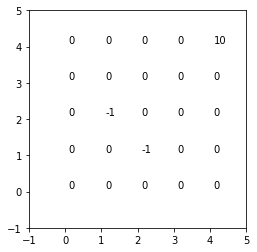

In [10]:
# Build a map

size = 5
map = np.array([
    [np.random.randint(0,1) for y in range(size)]
    for x in range(size)
])
map[2,1] = -1
map[1,2] = -1
map[4,4] = 10
for x in range(size):
    for y in range(size):
        plt.text(x+0.1,y+0.1,"%d" % map[x][y])
        
plt.xlim(-1,size)
plt.ylim(-1,size);
plt.gca().set_aspect(1) 

array([[ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  1.,  0.],
       [ 2.,  0.,  3., -1.],
       [ 2.,  1.,  3.,  0.],
       [ 2.,  2.,  3.,  0.],
       [ 2.,  3.,  0.,  0.],
       [ 1.,  3.,  2., -1.],
       [ 1.,  2.,  1.,  0.],
       [ 2.,  2.,  2., -1.],
       [ 2.,  1.,  2.,  0.],
       [ 2.,  0.,  0.,  0.],
       [ 1.,  0.,  2.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.]])

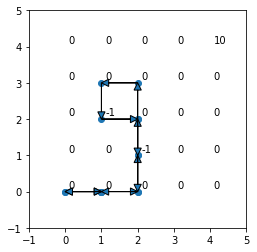

In [13]:
# Make an initial policy

policy0 = np.array([
    [
        [0.25, 0.25, 0.25, 0.25] for y in range(size)
    ] for x in range(size)
])

tau = sample(policy0,15)
show_trajectory(tau);
tau

Step 100, Reward: 80.000000

Text(0, 0.5, 'Reward')

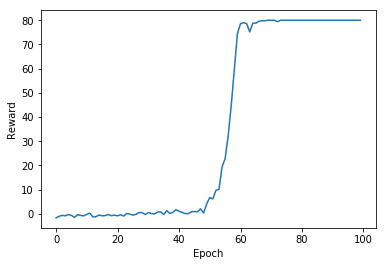

In [29]:
# The REINFORCE algorithm

# Number of epochs
epochs = 100

# Number of samples per epoch
num = 50

# Learning rate (nominally 0.01)
rate = 0.01

Rdata = np.array([])

policy = policy0

for i in range(epochs):
    samples = [sample(policy,15) for i in range(num)]
    R = sum([sum(s[:,3]) for s in samples])/len(samples) # Used as a baseline
    Rdata = np.append(Rdata,R)
    sys.stdout.write("\rStep %d, Reward: %lf" % (i+1,R))
    dJ = sum([
           sum([dlogpol(policy,s[t,0],s[t,1],s[t,2])*(sum(s[t:,3])-R)
              for t in range(10)]) 
           for s in samples
    ])/len(samples)
    policy = normalize(policy + rate * dJ)
    
plt.plot(Rdata);
plt.xlabel("Epoch")
plt.ylabel("Reward")

<module 'matplotlib.pyplot' from '/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

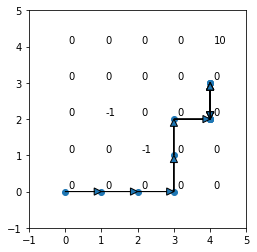

In [23]:
# Show a trajectory from the optimized policy
show_trajectory(sample(policy,15))

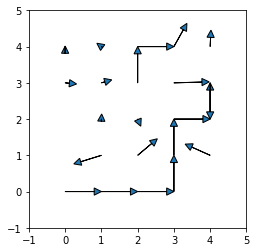

In [24]:
# Visualize the policy

for x in range(size):
    for y in range(size):  
        dx = -1*policy[x,y,0] + 1*policy[x,y,1]
        dy = -1*policy[x,y,2] + 1*policy[x,y,3]
        if ( x+dx < size and x+dx >= 0 and
             y+dy < size and y+dy >= 0 ):        
            plt.arrow(x,y,dx,dy,
                     length_includes_head=True, head_width=0.2, head_length=0.2)
        
plt.xlim(-1,size)
plt.ylim(-1,size);
plt.gca().set_aspect(1)        